# Variational Autoencoder (VAE) Tutorial

This notebook demonstrates how to implement and train a Variational Autoencoder (VAE) on the SVHN dataset. It includes steps for data preparation, model definition, training, and generating samples.


## 1. Importing Libraries

We start by importing the necessary libraries for data handling, model definition, and visualization.

In [1]:
import random
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt
from pathlib import Path

## 2. Setting Up Utilities

### Experiment Utilities
To ensure reproducibility, we fix random seeds. Additionally, we define the device for training (GPU if available).


In [2]:
def fix_experiment_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_experiment_seed()

results_folder = Path("./results")
results_folder.mkdir(exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

### Visualization Helper Function
This function helps us visualize batches of images.

In [3]:
def show_image(image, nrow=8):
    grid_img = make_grid(image.detach().cpu(), nrow=nrow, padding=0)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")

## 3. Dataset Preparation

We use the SVHN dataset (Street View House Numbers), a real-world image dataset containing digits captured from house numbers in street view images. The images are resized to 32x32 pixels and normalized to a range of [-1, 1].

100%|██████████| 182M/182M [00:02<00:00, 86.4MB/s]


100%|██████████| 64.3M/64.3M [00:01<00:00, 39.7MB/s]


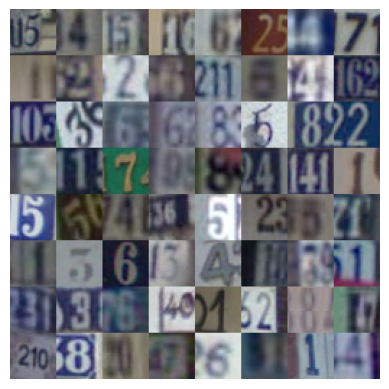

In [4]:
# Dataset parameters
image_size = 32
input_channels = 3
data_root = './data'
train_batch_size = 64

# DataLoader
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    normalize,
])

def get_dataloaders(batch_size):
    train = datasets.SVHN(data_root, split='train', download=True, transform=transform)
    test = datasets.SVHN(data_root, split='test', download=True, transform=transform)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)
    return train_dataloader, test_dataloader

train_dataloader, _ = get_dataloaders(train_batch_size)

# Visualizing the dataset
imgs, _ = next(iter(train_dataloader))
save_image((imgs + 1) * 0.5, './results/orig.png')
show_image((imgs + 1) * 0.5)

## 4. VAE Model Definition

A Variational Autoencoder consists of two main parts:

- **Encoder**: Maps input images to a latent space.
- **Decoder**: Reconstructs images from the latent space representation.

### Encoder and Decoder
The encoder compresses the input, while the decoder reconstructs the input from the latent representation.

In [5]:
class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1), nn.LeakyReLU(0.2), nn.BatchNorm2d(nef),
            nn.Conv2d(nef, nef * 2, 4, 2, padding=1), nn.LeakyReLU(0.2), nn.BatchNorm2d(nef * 2),
            nn.Conv2d(nef * 2, nef * 4, 4, 2, padding=1), nn.LeakyReLU(0.2), nn.BatchNorm2d(nef * 4),
            nn.Conv2d(nef * 4, nef * 8, 4, 2, padding=1), nn.LeakyReLU(0.2), nn.BatchNorm2d(nef * 8)
        )

    def forward(self, inputs):
        batch_size = inputs.size(0)
        hidden = self.encoder(inputs).view(batch_size, -1)
        return hidden


class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf * 8 * self.out_size * self.out_size), nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf * 8, ndf * 4, 3, 1, padding=1), nn.LeakyReLU(0.2),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf * 4, ndf * 2, 3, 1, padding=1), nn.LeakyReLU(0.2),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf * 2, ndf, 3, 1, padding=1), nn.LeakyReLU(0.2),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, 1, padding=1)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(batch_size, self.ndf * 8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

class VAE(nn.Module):
    def __init__(self, nc, nef, ndf, nz, isize, device):
        super(VAE, self).__init__()
        self.encoder = Encoder(nc, nef, nz, isize)
        self.decoder = Decoder(nc, ndf, nz, isize)
        self.nz = nz
        self.device = device

        # Latent space transformations
        self.fc_mu = nn.Linear(nef * 8 * (isize // 16) ** 2, nz)
        self.fc_logvar = nn.Linear(nef * 8 * (isize // 16) ** 2, nz)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        batch_size = x.size(0)

        # Encode
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decode
        recon = self.decoder(z)
        recon_loss = nn.MSELoss(reduction="none")(recon, x).sum(dim=[1, 2, 3])

        # KL divergence
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

        return recon, recon_loss, kl_div

    def sample(self, n_samples):
        z = torch.randn(n_samples, self.nz).to(self.device)
        samples = self.decoder(z)
        return samples

    def log_likelihood(self, x):
        recon, recon_loss, kl_div = self.forward(x)
        return -1 * (recon_loss + kl_div)


## 5. Training the VAE

Here, we define the VAE, optimizer, and the training loop. The training objective combines reconstruction loss and the KL divergence.



In [6]:
# Define VAE
z_dim = 32
vae = VAE(input_channels, 32, 32, z_dim, image_size, device)
vae.to(device)
optimizer = Adam(vae.parameters(), lr=1e-4)

# Train
epochs = 30
for epoch in range(epochs):
    with tqdm(train_dataloader, unit="batch") as tepoch:
        vae.train()
        for imgs, _ in tepoch:
            imgs = imgs.to(device)

            optimizer.zero_grad()
            recon, nll, kl = vae(imgs)
            loss = (nll + kl).mean()

            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=loss.item())

# Save results
samples = vae.sample(64)
save_image((samples + 1) * 0.5, './results/samples_final.png')

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

  0%|          | 0/1144 [00:00<?, ?batch/s]

## 6. Results and Visualization

### Visualizing Reconstructed Samples
We generate new samples from the latent space and visualize them.

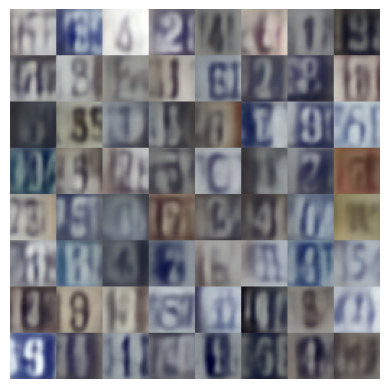

In [7]:
# Visualizing final samples
samples = vae.sample(64)
show_image((samples + 1) * 0.5)

### Log Likelihood Estimation
To evaluate the model, we estimate the log-likelihood of test data.

In [8]:
_, test_dataloader = get_dataloaders(train_batch_size)
with torch.no_grad():
    log_likelihood = 0.
    num_samples = 0.
    for imgs, _ in test_dataloader:
        imgs = imgs.to(device)
        log_likelihood += vae.log_likelihood(imgs).sum()
        num_samples += imgs.size(0)
    log_likelihood /= num_samples
    print(f"Log Likelihood: {log_likelihood.item()}")

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Log Likelihood: -87.92231750488281


### Interpolation in Latent Space
We interpolate between two points in the latent space to visualize the transition between generated samples.

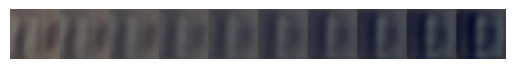

In [12]:
# Generate two random points in latent space
vae.eval()
z1 = torch.randn(1, z_dim).to(device)
z2 = torch.randn(1, z_dim).to(device)

# Interpolate between z1 and z2
steps = 10
interpolations = torch.cat([z1 * (1 - alpha) + z2 * alpha for alpha in torch.linspace(0, 1, steps)], dim=0)

# Decode interpolations
interpolated_images = vae.decoder(interpolations)
show_image((interpolated_images + 1) * 0.5, nrow=steps)


### Understanding the Results
- Generated Samples: The generated samples show the VAE's ability to create diverse, realistic images from the latent space.

- Log Likelihood: The computed log likelihood gives a measure of how well the VAE represents the data distribution.

- Latent Space Interpolation: The smooth transitions in interpolation reveal that the VAE captures meaningful structure in the data, ensuring latent space continuity.


### Insights Learned
- The VAE successfully encodes and decodes the SVHN dataset, preserving key visual features.

- The latent space is continuous, allowing interpolation between points and generation of realistic variations.

- While results are promising, improving reconstruction fidelity or applying the model to other datasets could further test its generalizability.